In [47]:
# This Notebook is for measuring the popularity of test items
from collections import Counter
from experiments.data_loader import DataLoader
from shared.enums import Sentiment
import numpy as np
from scipy import stats 
from matplotlib import pyplot as plt 
import seaborn as sns

data_loader = DataLoader('../../../data/equal/split_0')

entity_ratings = dict()

for user, ratings in data_loader.training().items():
    for item, rating in ratings.training.items():
        entity_ratings[item] = entity_ratings.get(item, 0) + 1
        pass

print(entity_ratings)

{7129: 556, 8: 906, 18450: 425, 9: 857, 4458: 945, 2982: 876, 1143: 205, 14021: 644, 5: 173, 1583: 967, 5359: 71, 13404: 56, 4395: 231, 1405: 451, 4994: 53, 15051: 68, 3731: 91, 4933: 12, 3566: 16, 11835: 32, 1566: 26, 14647: 25, 17597: 3, 16958: 17, 2921: 25, 4705: 7, 6052: 15, 11958: 8, 5877: 5, 14862: 11, 153: 11, 5783: 9, 17421: 11, 5412: 6, 16106: 2, 9209: 5, 3854: 1, 15803: 2, 2291: 3, 4685: 112, 13233: 717, 12160: 358, 4592: 273, 17689: 268, 7: 744, 2750: 376, 9866: 554, 4148: 113, 15849: 205, 14795: 42, 186: 283, 5430: 48, 10835: 59, 8296: 72, 16419: 4, 3934: 66, 9154: 79, 11133: 128, 5798: 61, 7073: 57, 3070: 43, 5835: 78, 5090: 16, 3334: 24, 9922: 14, 1636: 67, 8590: 18, 13609: 89, 4678: 9, 15496: 10, 1932: 4, 2977: 651, 5173: 87, 17697: 546, 3986: 23, 3057: 361, 15334: 94, 1850: 93, 12793: 72, 2871: 8, 4707: 174, 6: 374, 4546: 45, 11269: 148, 4499: 139, 992: 36, 7037: 45, 5095: 157, 13606: 84, 13408: 69, 15030: 34, 4: 75, 15538: 14, 4525: 42, 3722: 8, 3739: 39, 15730: 12, 15

np.mean(differences)=10.093717595425911
DescribeResult(nobs=434, minmax=(1, 180), mean=46.70276497695853, variance=1727.230154000064, skewness=1.1198262723150343, kurtosis=0.632185442500389)
np.median(positive_ratings)=34.5
DescribeResult(nobs=43400, minmax=(1, 180), mean=37.08566820276498, variance=821.4849532390637, skewness=0.9964454428327097, kurtosis=1.0441471002896234)
np.median(unseen_ratings)=32.0
30.0
2.0


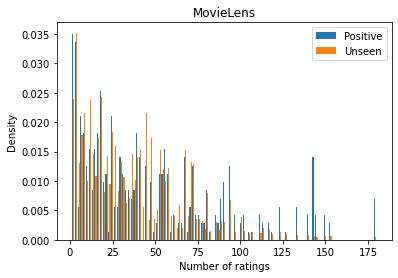

In [48]:
# How popular are positive items compared to unseen samples

positive_ratings = list()
unseen_ratings = list()
differences = list()

for user, ratings in data_loader.testing().items():
    items = set()
    for cold_set in ratings.sets:
        positive_items = cold_set.ranking.sentiment_samples[Sentiment.POSITIVE]
        unseen_items = cold_set.ranking.sentiment_samples[Sentiment.UNSEEN]
        
        for item in positive_items:
            positive_ratings.append(entity_ratings.get(item, 0))
            
        for item in unseen_items:
            unseen_ratings.append(entity_ratings.get(item, 0))
            
        differences.append(np.mean(positive_ratings) - np.mean(unseen_ratings))

print(f'{np.mean(differences)=}')
print(stats.describe(positive_ratings))
print(f'{np.median(positive_ratings)=}')
print(stats.describe(unseen_ratings))
print(f'{np.median(unseen_ratings)=}')

print(f'{np.percentile(positive_ratings, 45)}')
print(f'{np.percentile(unseen_ratings, 3)}')
plt.hist([positive_ratings, unseen_ratings], bins=109, label=['Positive', 'Unseen'], density=True)
plt.legend(loc='upper right')
plt.xlabel('Number of ratings')
plt.ylabel('Density')
plt.title('MovieLens')
plt.savefig('sampling_popularity_bias.pdf', bbox_inches='tight')

In [49]:
# How many unique positive samples we have per test user
test_ratings = dict()
unseen_ratings = dict()
lengths = []

for user, ratings in data_loader.testing().items():
    items = set()
    for cold_set in ratings.sets:
        positive_items = cold_set.ranking.sentiment_samples[Sentiment.POSITIVE]
        
        items.update(positive_items)

    lengths.append(len(items))

print(stats.describe(lengths))

DescribeResult(nobs=434, minmax=(1, 1), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


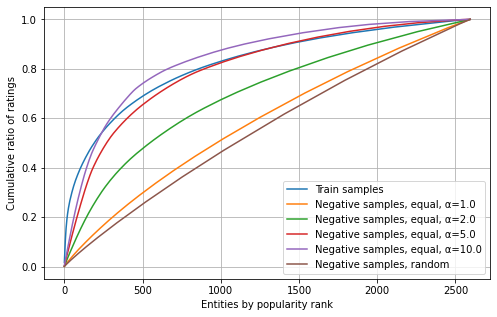

In [50]:
# Comparison of different sampling strategies\n
def get_num_ratings(path):
    data_loader = DataLoader(path)
    training = data_loader.training()
    testing = data_loader.testing()

    train_ratings = []
    train_pos_rating = []
    for user, warm in training.items():
        for entity, rating in warm.training.items():
            train_ratings.append(entity)
            if rating == 1:
                train_pos_rating.append(entity)

    r_train = Counter(train_ratings)
    pr_train = Counter(train_pos_rating)

    test_answ_ratings = []
    test_pos_answ_ratings = []
    test_ratings = []
    test_pos_ratings = []

    for user, cold in testing.items():
        for set in cold.sets:
            for entity, rating in set.answers.items():
                test_answ_ratings.append(entity)
                if rating == 1:
                    test_pos_answ_ratings.append(entity)
            for entity in set.ranking.get_seen_samples():
                test_pos_ratings.append(entity)
            t = set.ranking.get_seen_samples()
            for entity in set.ranking.to_list():
                if entity not in set.ranking.get_seen_samples():
                    test_ratings.append(entity)

    r_test_ans = Counter(test_answ_ratings)
    pr_test_ans = Counter(test_pos_answ_ratings)
    r_test = Counter(test_ratings)
    pr_test = Counter(test_pos_ratings)

    return r_train, pr_train, r_test_ans, pr_test_ans, r_test, pr_test

def cumulative_ratio(ordered_values):
    tot = 0
    array = np.zeros((len(ordered_values),))
    for i, val in enumerate(ordered_values):
        tot += val
        array[i] = tot

    return array / tot

def sort_args(*args):
    return [
    sorted(r.items(), key=lambda x: x[1], reverse=True) for r in args
]


r_train, _, _, _, r_test, _ = sort_args(*get_num_ratings('../../../data/equal/split_0'))
_,y1 = zip(*r_train)
_,y2 = zip(*r_test)

_, _, _, _, r_test, _ = sort_args(*get_num_ratings('../../../data/equalalpha1.0/split_0'))
_,y6 = zip(*r_test)

_, _, _, _, r_test, _ = sort_args(*get_num_ratings('../../../data/equalalpha2.0/split_0'))
_,y7 = zip(*r_test)

_, _, _, _, r_test, _ = sort_args(*get_num_ratings('../../../data/equalalpha5.0/split_0'))
_,y8 = zip(*r_test)

_, _, _, _, r_test, _ = sort_args(*get_num_ratings('../../../data/equal/split_0'))
_,y9 = zip(*r_test)


_, _, r_test_ans, _, r_test, pr_test = sort_args(*get_num_ratings('../../../data/uniform/split_0'))
_,y3 = zip(*pr_test)
_,y4 = zip(*r_test)
_,y5 = zip(*r_test_ans)

r = min(len(y1),
        len(y2),
        # len(y3),
        len(y4),
        # len(y5),
        len(y6),
        len(y7),
        len(y8),
        len(y9)
        )
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(range(r), cumulative_ratio(y1[:r]), label = "Train samples")
# plt.plot(range(r), cumulative_ratio(y5[:r]), label= 'Test answer samples')
# plt.plot(range(r), cumulative_ratio(y2[:r]), label= 'Unseen samples, equal, alpha: 0.5')
plt.plot(range(r), cumulative_ratio(y6[:r]), label= 'Negative samples, equal, α=1.0')
plt.plot(range(r), cumulative_ratio(y7[:r]), label= 'Negative samples, equal, α=2.0')
plt.plot(range(r), cumulative_ratio(y8[:r]), label= 'Negative samples, equal, α=5.0')
plt.plot(range(r), cumulative_ratio(y9[:r]), label= 'Negative samples, equal, α=10.0')
# plt.plot(range(r), cumulative_ratio(y3[:r]), label = \"Seen samples, uniform\")
plt.plot(range(r), cumulative_ratio(y4[:r]), label= 'Negative samples, random')

plt.legend()
# plt.yscale('log')
plt.xlabel('Entities by popularity rank')
plt.ylabel('Cumulative ratio of ratings')


plt.grid()

plt.savefig('../results/cumulative_sampling.pdf', bbox_inches='tight')
plt.show()
